In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

import paragami

from numpy.polynomial.hermite import hermgauss

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 16


from bnpmodeling_runjingdev import result_loading_utils

from structure_vb_lib import structure_model_lib, posterior_quantities_lib, data_utils

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

In [3]:
plt.rcParams['axes.titlesize'] = 18

# File paths

In [4]:
data_file = '../data/thrush_data/thrush-data.str'
out_filename = 'thrush_fit'
out_folder = '../fits/thrush_fits/'

In [5]:
alpha0 = 3.0

# class with method to load all files from a particular perturbation

result_loader = result_loading_utils.FunctionalRefitsLoader(alpha0, 
                                                            out_folder, 
                                                            out_filename)

loading initial fit from:  ../fits/thrush_fits/thrush_fit_alpha3.0.npz
loading lr derivatives from:  ../fits/thrush_fits/thrush_fit_alpha3.0_lrderivatives.npz


# Load data

In [6]:
g_obs, _, labels, _ = data_utils.load_thrush_data(data_file)

loading thrush data from : 
../data/thrush_data/thrush-data.str


In [7]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]
n_allele = g_obs.shape[-1]


# Load initial fit and its metadata

In [8]:
vb_init_free = result_loader.vb_init_free
vb_params_paragami = result_loader.vb_params_paragami
vb_init_dict = vb_params_paragami.fold(vb_init_free, free = True)

In [9]:
vb_init_free = vb_params_paragami.flatten(vb_init_dict, free = True)

In [10]:
print(vb_params_paragami)

OrderedDict:
	[pop_freq_dirichlet_params] = NumericArrayPattern (20, 7, 21) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (155, 19) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (155, 19) (lb=0.0, ub=inf)


In [11]:
# gauss-hermite parameters
gh_deg = int(result_loader.init_fit_meta_data['gh_deg'])
gh_loc, gh_weights = hermgauss(gh_deg)

gh_loc = np.array(gh_loc)
gh_weights = np.array(gh_weights)
    
# load prior parameters
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params(n_allele)

# set initial alpha
assert alpha0 == result_loader.init_fit_meta_data['dp_prior_alpha']
prior_params_dict['dp_prior_alpha'] = alpha0

print(prior_params_dict)


{'dp_prior_alpha': 3.0, 'allele_prior_lambda_vec': DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1.], dtype=float64)}


# Define number of clusters

In [12]:
import bnpmodeling_runjingdev.exponential_families as ef
from bnpmodeling_runjingdev import cluster_quantities_lib  

In [13]:
seed = 2342
key = jax.random.PRNGKey(seed)

@jax.jit
def get_e_num_clusters(vb_params_free): 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    return posterior_quantities_lib.get_e_num_clusters(g_obs, 
                                                       vb_params_dict,
                                                       gh_loc,
                                                       gh_weights, 
                                                       n_samples = 1000,
                                                       threshold = 0,
                                                       prng_key = key)

@jax.jit
def get_e_num_pred_clusters(vb_params_free): 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    return posterior_quantities_lib.get_e_num_pred_clusters(vb_params_dict,
                                                       gh_loc,
                                                       gh_weights, 
                                                       n_samples = 1000,
                                                       threshold = 0,
                                                       prng_key = key)

### Thresholded

In [14]:
threshold1 = np.ceil(g_obs.shape[0] * g_obs.shape[1] * 2 * 0.01)
threshold2 = np.ceil(g_obs.shape[0] * 0.01)

@jax.jit
def get_e_num_clusters_thresh(vb_params_free): 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    return posterior_quantities_lib.get_e_num_clusters(g_obs, 
                                                       vb_params_dict,
                                                       gh_loc,
                                                       gh_weights, 
                                                       n_samples = 1000,
                                                       threshold = threshold1,
                                                       prng_key = key)

@jax.jit
def get_e_num_pred_clusters_thresh(vb_params_free): 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    return posterior_quantities_lib.get_e_num_pred_clusters(vb_params_dict,
                                                       gh_loc,
                                                       gh_weights, 
                                                       n_samples = 1000,
                                                       threshold = threshold2,
                                                       prng_key = key)

# expected allocations

In [15]:
@jax.jit
def get_e_num_ind(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.get_e_num_ind_per_cluster(vb_params_dict, 
                                                              gh_loc,
                                                              gh_weights)


@jax.jit
def get_e_num_loci(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.get_e_num_loci_per_cluster(g_obs, 
                                                               vb_params_dict,
                                                               gh_loc,
                                                               gh_weights)

### Plot initial

In [16]:
e_num_ind_init = get_e_num_ind(vb_init_free)
e_num_loci_init = get_e_num_loci(vb_init_free)

In [ ]:
fig, axarr = plt.subplots(1, 2, figsize = (10, 4))

result_loading_utils._plot_weights(e_num_ind_init, 
                                   axarr[0])

result_loading_utils._plot_weights(e_num_loci_init, 
                                   axarr[1])


axarr[0].set_ylabel('E[# loci]')
axarr[1].set_ylabel('E[# ind]')

for i in range(2): 
    axarr[i].set_xticks(np.arange(20, step = 2))
    axarr[i].set_xlabel('latent population')

fig.tight_layout();

fig.savefig('../../writing/notes_for_tamara/figures/structure_init_allocations.png')

### Function to make trace plot of expected allocations

In [18]:
def plot_e_num_obs_trace(vb_refit_list, lr_list, epsilon_vec, ax): 
    
    # get arrays of mixture weights
    refit_array = result_loading_utils.get_post_stat_vec(get_e_num_loci, vb_refit_list)
    lr_array = result_loading_utils.get_post_stat_vec(get_e_num_loci, lr_list)
        
    for k in range(4): 

        ax[k].plot(epsilon_vec, 
                       refit_array[:, k], 
                       '-o',
                       color = result_loading_utils.refit_color, 
                       label = 'refit')
        
        ax[k].plot(epsilon_vec, 
                       lr_array[:, k], 
                       '-o',
                       color = result_loading_utils.lr_color, 
                       label = 'lr')
        
        ax[k].set_title('k = {}'.format(k))
        
        if k == 0: 
            ax[k].legend()
            
        ax[k].set_xlabel('epsilon')        
 
    ax[0].set_ylabel('E(# loci)')
    
    fig.tight_layout()


# Function to plot results

In [19]:
def plot_results_for_perturbation(perturbation, delta): 
    
    #################
    # load free parameters
    #################
    vb_refit_list, lr_list, epsilon_vec = \
        result_loader.get_free_param_results_from_perturbation(perturbation, delta)
    assert (vb_refit_list[0] == lr_list[0]).all()
    
    fig, ax = plt.subplots(3, 4, figsize = (18, 12))
    
    #################
    # Plot perturbation
    #################
    result_loading_utils.plot_perturbation(perturbation, delta, alpha0, 
                                           ax = ax[0])

    #################
    # in-sample number of clusters
    #################
    
    # not-thresholded
    result_loading_utils.plot_post_stat_per_epsilon(get_e_num_clusters, 
                                                    vb_refit_list,
                                                    lr_list,
                                                    epsilon_vec,
                                                    ax[1, 0])
    
    # thresholded
    result_loading_utils.plot_post_stat_per_epsilon(get_e_num_clusters_thresh, 
                                                    vb_refit_list,
                                                    lr_list,
                                                    epsilon_vec,
                                                    ax[1, 1])
    ax[1, 0].set_title('in-sample')
    ax[1, 1].set_title('in-sample; thresh = {}'.format(threshold1))
    ax[1, 0].legend()
    
    #################
    # predictive number of clusters
    #################
    result_loading_utils.plot_post_stat_per_epsilon(get_e_num_pred_clusters, 
                                                    vb_refit_list,
                                                    lr_list,
                                                    epsilon_vec,
                                                    ax[1, 2])
    # thresholded
    result_loading_utils.plot_post_stat_per_epsilon(get_e_num_pred_clusters_thresh, 
                                                    vb_refit_list,
                                                    lr_list,
                                                    epsilon_vec,
                                                    ax[1, 3])
    ax[1, 2].set_title('predictive')
    ax[1, 3].set_title('predictive; thresh = {}'.format(threshold2))
    ax[1, 0].set_ylabel('E[# clusters]')
    
    # trace plot of mixture weights 
    plot_e_num_obs_trace(vb_refit_list, lr_list, epsilon_vec, ax[2])
    
    
    fig.tight_layout();
    
    fig.savefig('../../writing/notes_for_tamara/figures/structure_' + perturbation + '_delta' + str(delta) + '_e_num_clust.png')

# Sigmoidal perturbations

Optim time at epsilon = 1: 7.218secs
Derivative time: 0.699secs


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.300350e-07
  warnings.warn(


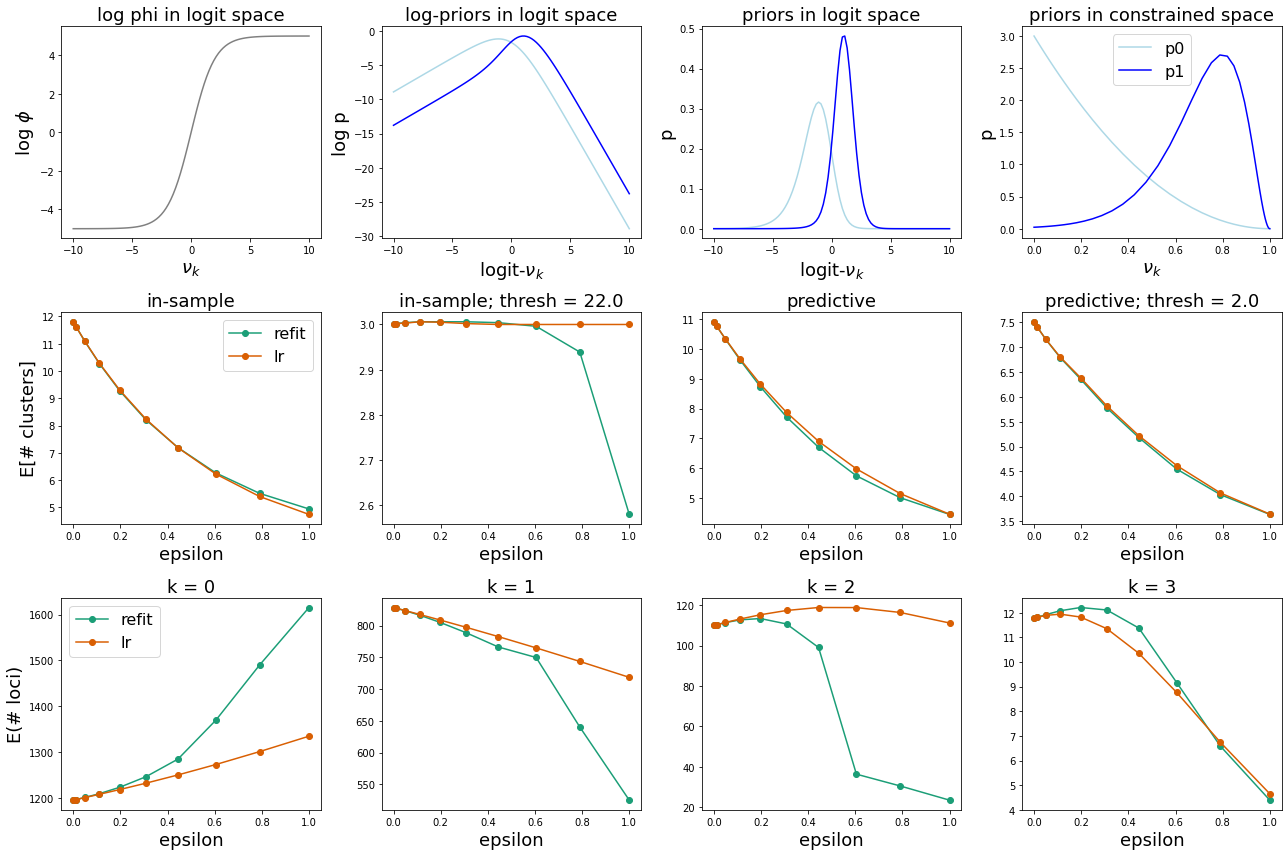

In [20]:
delta = 5
perturbation = 'sigmoidal'

plot_results_for_perturbation(perturbation, delta)

Optim time at epsilon = 1: 12.411secs
Derivative time: 0.699secs


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.735899e-07
  warnings.warn(


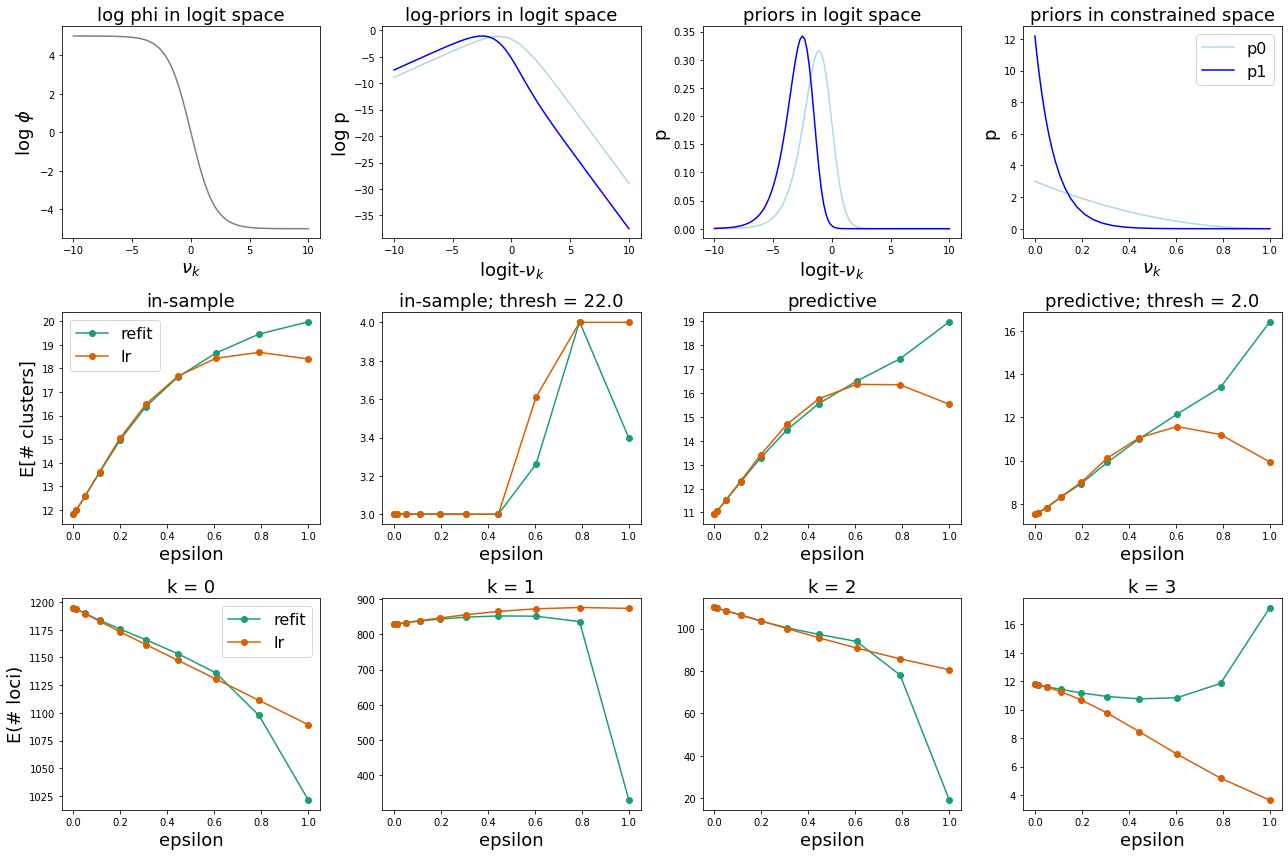

In [21]:
perturbation = 'sigmoidal'
delta = -5
plot_results_for_perturbation(perturbation, delta)

# Perturbing the alpha parameter upwards 
## (using a functional perturbation)

Optim time at epsilon = 1: 7.334secs
Derivative time: 0.669secs


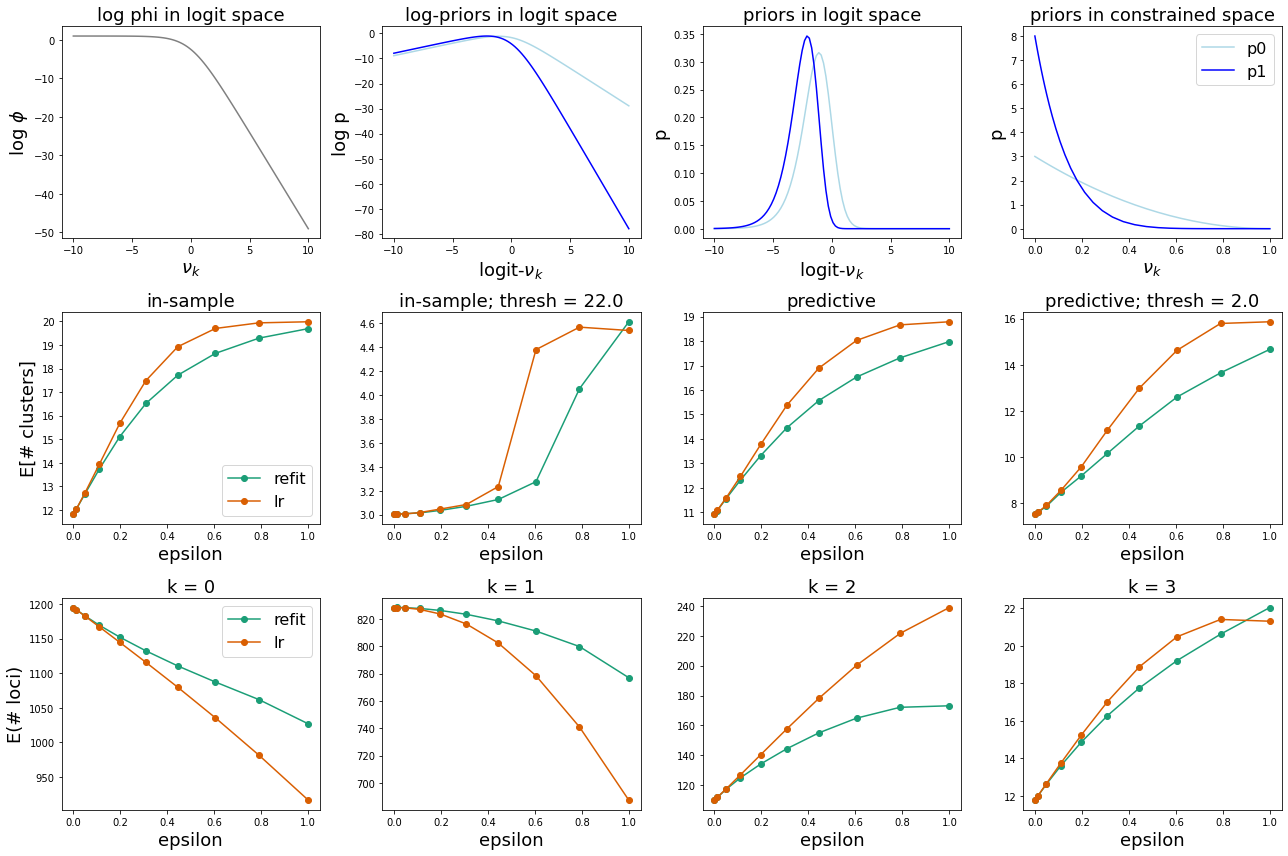

In [22]:
perturbation = 'alpha_pert_pos'
delta = 1
plot_results_for_perturbation(perturbation, delta)

# Perturb alpha parameter downwards

In [23]:
# perturbation = 'alpha_pert_neg'
# delta = 1
# result_loading_utils.plot_perturbation(perturbation, delta, alpha0)
# plot_results_for_perturbation(perturbation, delta)

# flip alpha perturbation along x-axis

In [24]:
# plot_stuff('alpha_pert_pos_xflip', delta = 1);

In [25]:
# plot_stuff('alpha_pert_neg_xflip', delta = 1);

# Perturb with Gaussian bumps

Optim time at epsilon = 1: 6.238secs
Derivative time: 0.715secs


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.453183e-06
  warnings.warn(


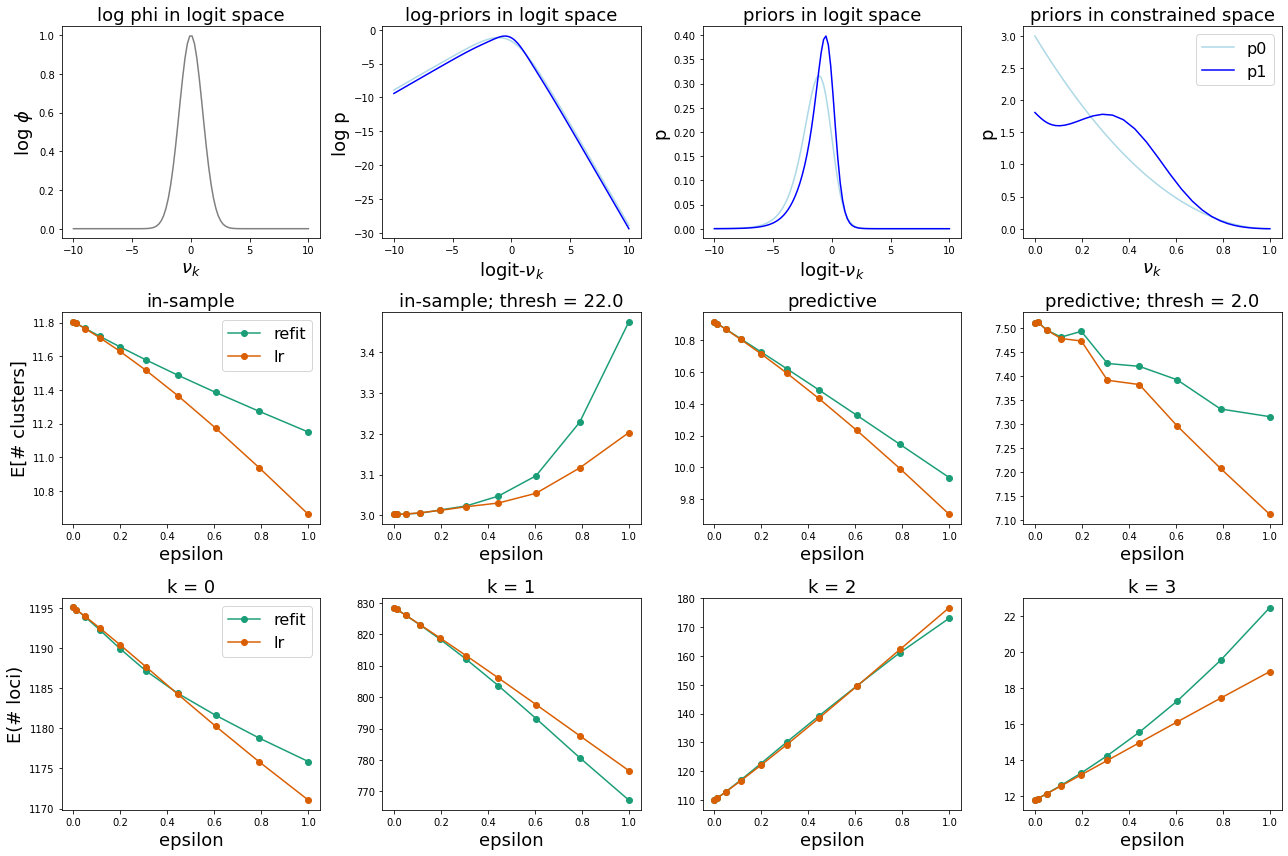

In [26]:
perturbation = 'gauss_pert1'
delta = 1

plot_results_for_perturbation(perturbation, delta)

Optim time at epsilon = 1: 8.320secs
Derivative time: 0.715secs


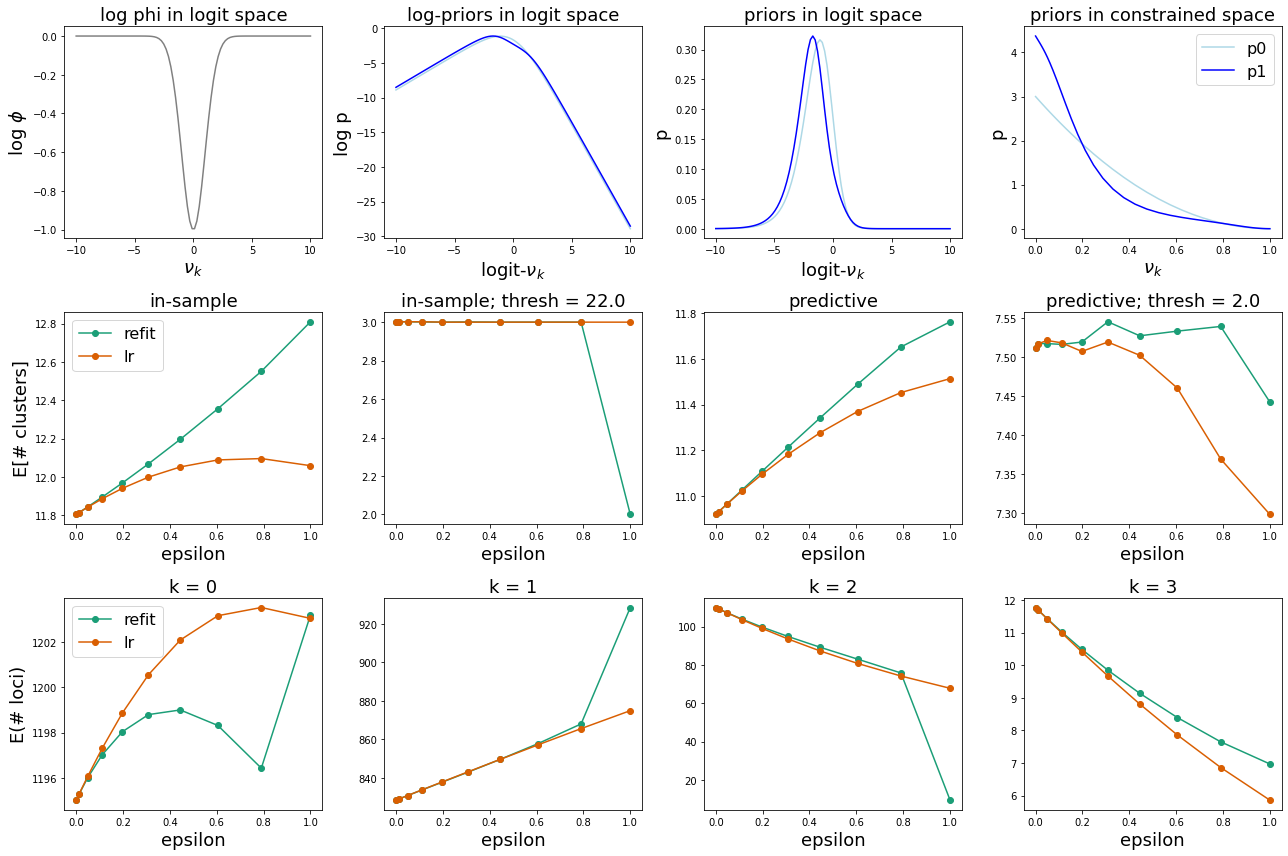

In [27]:
perturbation = 'gauss_pert1'
delta = -1

plot_results_for_perturbation(perturbation, delta)

Optim time at epsilon = 1: 7.596secs
Derivative time: 0.712secs


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.565685e-07
  warnings.warn(


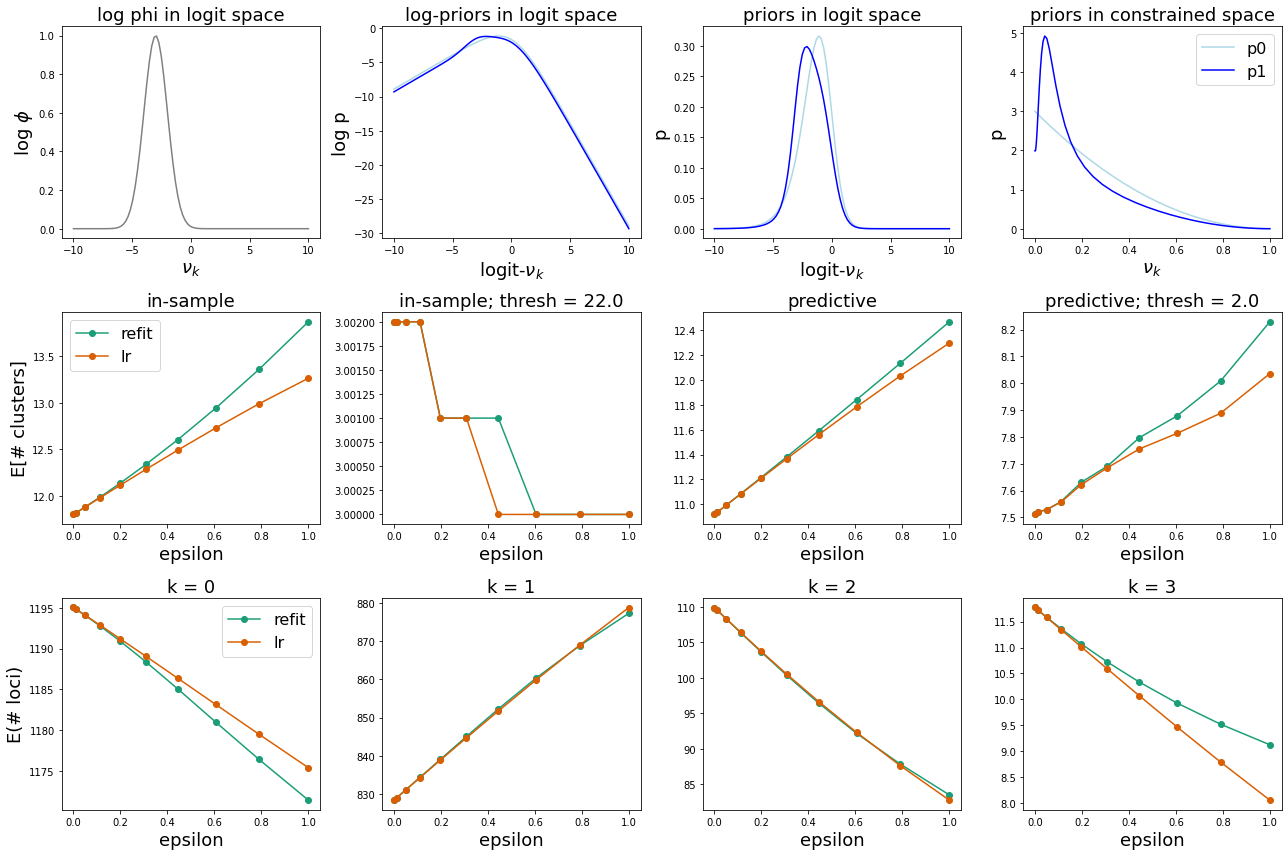

In [28]:
perturbation = 'gauss_pert2'
delta = 1

plot_results_for_perturbation(perturbation, delta)

Optim time at epsilon = 1: 3.891secs
Derivative time: 0.712secs


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.349213e-08
  warnings.warn(


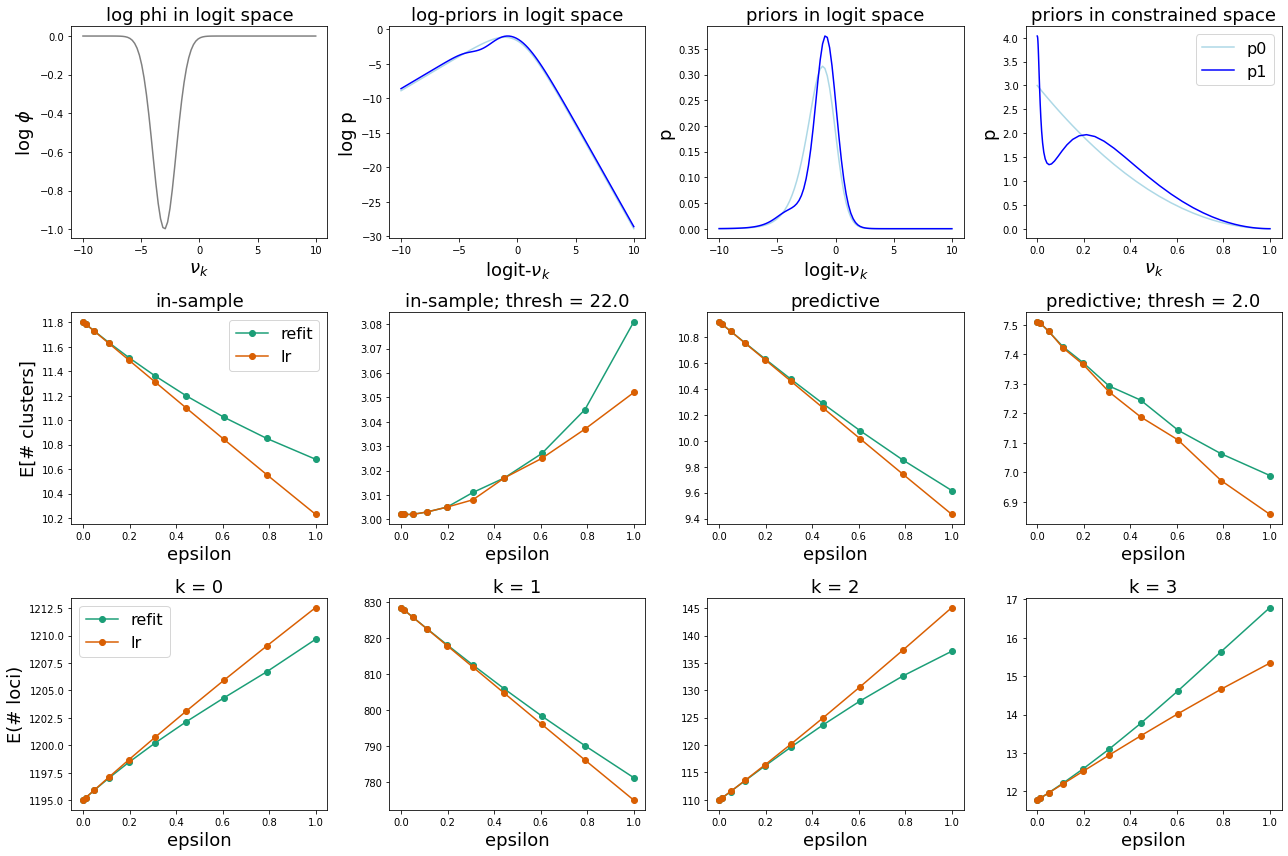

In [29]:
perturbation = 'gauss_pert2'
delta = -1

plot_results_for_perturbation(perturbation, delta)